# Задание 3
## Генерация данных

$-a_2 = a_1 = a_0 = 1$ (в коде - массив $a$)

$\sigma^2 = 0.1$ (в коде - $var$)

In [90]:
import numpy as np
from scipy.stats import norm, uniform, randint
from scipy.special import expit
from scipy.optimize import linprog
import matplotlib.pyplot as plt
%matplotlib inline

In [91]:
def get_sample(M, var, origin):
    return origin + norm.rvs(size=M, scale=np.sqrt(var))

    
M = 200
t = np.array(range(M)) * 10 / M

a = np.array([-1, 1, 1])

fun = lambda t, a: (a * np.array([np.sin(t), t, 1])).sum()

var = 0.1

origin = fun(t, a)
sample = get_sample(M, var, origin)

## Решение задач оптимизации

Просят решить три задачи оптимизации.

   * Минимизировать сумму квадратов ошибок. Эту задачу решает метод наименьших квадратов:
   
Пусть $ T = \begin{pmatrix}
    sin(t_0) & t_0 & 1 \\
    sin(t_1) & t_1 & 1 \\
    \vdots & \vdots & \vdots \\
    sin(t_{m - 1}) & t_{m - 1} & 1
  \end{pmatrix} $, $b = \begin{pmatrix}y_0 \\ y_1 \\ \vdots \\ y_{m - 1}\end{pmatrix}$, $a = \begin{pmatrix}a_2 \\ a_1 \\ a_0 \end{pmatrix}$

Тогда задача минимизации записывается как $|T \vec{a} - \vec{b}| \to min$ и имеет решение $\vec{a} = (T^T T)^{-1}T^T \vec{b}$
   * Минимизировать сумму модулей ошибок.
Это решается с помощью следующей задачи ЛП:

Переменные: $\{v_2, u_2, v_1, u_1, v_0, u_0, \delta_0, \delta_1, ..., \delta_{m - 1}\}$

$\vec{a} = \begin{pmatrix}v_2 - u_2 \\ v_1 - u_1 \\ v_0 - u_0 \end{pmatrix}$

$T\vec{a} - \vec{\delta} \le \vec{b}$

$-T\vec{a} - \vec{\delta} \le -\vec{b}$

$\sum{\delta_i} \to min$
   
   * Минимизировть максимум ошибки.
Это та же задача ЛП, только вместо $\delta_0, \delta_1, \delta_2$ считаем, что за ошибку отвечает только одна переменная $\delta$ и минимизируем её:

Переменные: $\{v_2, u_2, v_1, u_1, v_0, u_0, \delta\}$

$\vec{a} = \begin{pmatrix}v_2 - u_2 \\ v_1 - u_1 \\ v_0 - u_0 \end{pmatrix}$

$\vec{\Delta} = \begin{pmatrix}\delta \\ \vdots \\ \delta \end{pmatrix}$

$T\vec{a} - \vec{\Delta} \le \vec{b}$

$-T\vec{a} - \vec{\Delta} \le -\vec{b}$

$\delta \to min$

PS: Утверждается, что scipy.optimize.linprog позволяет проводить симплекс-метод без условия неотрицательности переменных. Решается это так, как показано выше, а в коде будет напрямую искаться вектор $\vec{a}$ 

In [92]:
# Метод наименьших квадратов
def get_lst2_a(t, sample):
    T = np.matrix([np.sin(t), t, np.array([1] * M)]).T

    return np.linalg.lstsq(T, sample)[0] # Да, именно он реализован в этой функции

In [118]:
# Первая задача ЛП
def get_lst1_a(t, sample):
    E = np.matrix(np.identity(len(t)))
    A = np.concatenate((T, -E), axis=1)
    A = np.concatenate((A, np.concatenate((-T, -E), axis=1)), axis=0)
    
    bounds = [(None, None)] * 3 + [(0, None)] * len(t) # Задаем границы значений переменных. 
    return linprog(c=([0] * 3 + [1] * len(t)), A_ub=A, b_ub=list(sample) + list(-sample), 
                   bounds=bounds, options={'disp': False, 
                                           'bland': False, 
                                           'tol': 1e-6, 
                                           'maxiter': 1000})['x'][:3]

In [143]:
# Вторая задача ЛП
def get_lstinf_a(t, sample):
    E = np.matrix(np.ones(len(t))).T # Вместо разных - всегда одна ошибка
    A = np.concatenate((T, -E), axis=1)
    A = np.concatenate((A, np.concatenate((-T, -E), axis=1)), axis=0)
    
    bounds = [(None, None)] * 3 + [(0, None)] # Задаем границы значений переменных. 
    return linprog(c=([0] * 3 + [1]), A_ub=A, b_ub=list(sample) + list(-sample), 
                   bounds=bounds, options={'disp': False, 
                                           'bland': False, 
                                           'tol': 1e-3, 
                                           'maxiter': 10000})['x'][:3]

In [144]:
a_2 = get_lst2_a(t, sample)
a_1 = get_lst1_a(t, sample)
a_inf = get_lstinf_a(t, sample)
print(a_2, a_1, a_inf, sep='\n')

[-1.02707385  0.99692881  1.00119324]
[-0.99555282  1.00624695  0.96077592]
[-0.98116458  0.9740039   1.05635844]


### Пункт a)

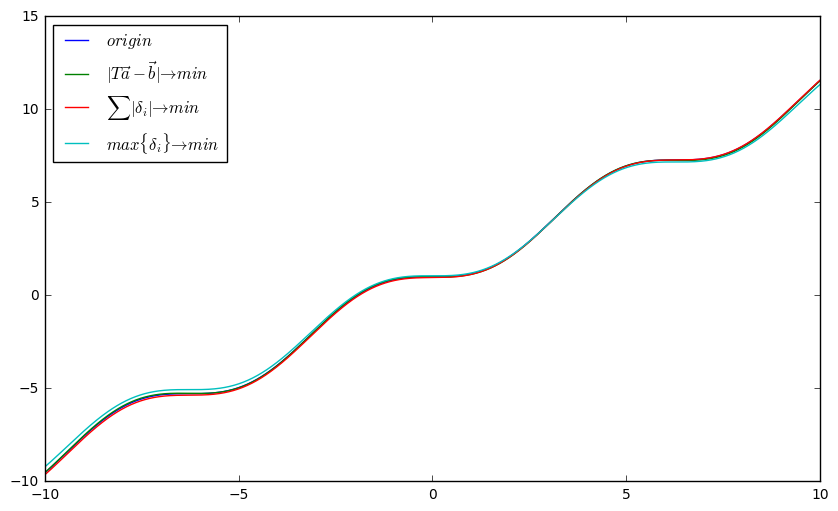

In [145]:
t_all = np.linspace(-10, 10, 1000)

plt.figure(figsize=(10, 6))

plt.plot(t_all, fun(t_all, a), label=r'$origin$')
plt.plot(t_all, fun(t_all, a_2), label=r'$|T \vec{a} - \vec{b}| \to min$')
plt.plot(t_all, fun(t_all, a_1), label=r'$\sum{|\delta_i|} \to min$')
plt.plot(t_all, fun(t_all, a_inf), label=r'$max \{\delta_i\} \to min$')

plt.legend(loc='upper left')
plt.show()

### Пункт b)
В пункте b) логично для $a^{(2)}$ посчитать модуль разности с истинным значением, для $a^{(1)}$ - сумму модулей разности, для $a^{(\infty)}$ - максимальную ошибку

In [146]:
def test_a_by_var(var):
    sample = get_sample(M, var, origin)
    a_2 = get_lst2_a(t, sample)
    a_1 = get_lst1_a(t, sample)
    a_inf = get_lstinf_a(t, sample)
    
    print(a_2, a_1, a_inf, sep='\n')
    
    print(np.sqrt(((a - a_2) ** 2).sum()))
    print(np.sum(np.abs(a - a_1)))
    print(np.max(np.abs(a - a_inf)))

In [147]:
test_a_by_var(0.01)

[-0.98885534  1.00171019  0.98139693]
[-0.98197441  1.00303632  0.96637374]
[-0.95745509  0.99247494  1.03548371]
0.0217532203778
0.0546881623402
0.0425449053909


In [148]:
test_a_by_var(1)

[-0.86996148  0.96536294  1.10196395]
[-0.93617628  0.97245668  1.08690083]
[-0.57001596  1.00186353  0.94890906]
0.168838356906
0.178267877364
0.429984041571


In [149]:
test_a_by_var(10)

[-1.03662716  1.03922094  1.12395649]
[-2.20905549  1.62423747 -1.24748399]
[ 0.70737624  1.09918562  0.86890687]
0.135074215648
4.08077694323
1.70737623786


Видно, что с увеличением дисперсии нужно больше итераций для сходимости симплекс-метода. Метод наименьших квадратов всегда прекрасен.